<div style="text-align: left">CSYE 7370 Deep Learning and Reinforcement Learning in Game Engineering</div>
<div style="text-align: left">Yucong Feng, 001586064</div>
<div style="text-align: left">Final Project</div>

## Application of ResNet50 on animal classification

**ABSTRACT**

The paper aims to use Residual Network 50 (ResNet50) [1] model to classify 12 kinds of animals. The dataset is consisted of different images which are collected from internet. 

The results show that we can successfully classify these animals based on the animal dataset, which means this can be a useful tool for image recognition in many fields. 

The image dataset of animals that I used can be found on AIStudio: https://aistudio.baidu.com/aistudio/datasetdetail/68755.


# 1	INTRODUCTION
With the decline of traditional taxonomy research, there are fewer and fewer taxonomy experts, but there are still a large number of animal and plant specimens and photos that need to be quickly identified and identified; at the same time, field natural education is gradually rising, which needs to be able to quickly identify species and provide relevant tools. Some popular image recognition networks, such as AlexNet, VGGNet, ResNet, and InceptionV1-V4 network, are widely used in image recognition. Since I want our classified image to have higher precision, I chose the ResNet50 as the network I use.

Residual Network 50 is a powerful tool in the state of image recognition. Many types of research have been conducted around this topic, and this mode advanced dramatically in recent years. This model was immensely successful, as can be ascertained from the fact that its ensemble won the top position at the ILSVRC 2015 classification competition with an error of only 3.57%. Additionally, it also came first in the ImageNet detection, ImageNet localization, COCO detection, and COCO segmentation in the ILSVRC & COCO competitions of 2015.

The dataset of animals is collected from the internet. Figure 1 shows a part of the dataset. This training dataset has a total of 12 different categories of animals, and each category has about 600 different images, a total of 7096 images.


# 2 Data preparation

## 2.1 Unzip the dataset

### Sample from dataset
![](https://ai-studio-static-online.cdn.bcebos.com/d279bfc657864d5a910ba98de641f63c7da83a85fd5347de8bf851c3baca3ea0)


In [1]:
!unzip -q -o data/data68755/signs.zip

## 2.2 Data annotation

```bash
.
├── test
│   ├── dog
│   ├── dragon
│   ├── goat
│   ├── horse
│   ├── monkey
│   ├── ox
│   ├── pig
│   ├── rabbit
│   ├── ratt
│   ├── rooster
│   ├── snake
│   └── tiger
├── train
│   ├── dog
│   ├── dragon
│   ├── goat
│   ├── horse
│   ├── monkey
│   ├── ox
│   ├── pig
│   ├── rabbit
│   ├── ratt
│   ├── rooster
│   ├── snake
│   └── tiger
└── valid
    ├── dog
    ├── dragon
    ├── goat
    ├── horse
    ├── monkey
    ├── ox
    ├── pig
    ├── rabbit
    ├── ratt
    ├── rooster
    ├── snake
    └── tiger
```
The data set is divided into three folders: train, valid, and test. Each folder contains **12 classification folders**, and each classification folder contains specific sample pictures.

We perform an annotation process on these samples, and finally generate three data annotation files:

1. **train.txt**, 
2. **valid.txt**, 
3. **test.txt**.

In [2]:
import io
import os
from PIL import Image
from config import get


# Dataset root directory
DATA_ROOT = 'signs'

# Tag List
LABEL_MAP = get('LABEL_MAP')

# callout generation function
def generate_annotation(mode):
    # Create annotation file
    with open('{}/{}.txt'.format(DATA_ROOT, mode), 'w') as f:
        # Data folders for each purpose: train/valid/test
        train_dir = '{}/{}'.format(DATA_ROOT, mode)

        # Traversing folders to get the classified folders inside
        for path in os.listdir(train_dir):
            # The numerical index corresponding to the label, directly use the numerical index when actually labeling
            label_index = LABEL_MAP.index(path)

            # The path where the image samples are located
            image_path = '{}/{}'.format(train_dir, path)

            # iterate over all images
            for image in os.listdir(image_path):
                # Image full path and name
                image_file = '{}/{}'.format(image_path, image)
                
                try:
                    # Verify image format
                    with open(image_file, 'rb') as f_img:
                        image = Image.open(io.BytesIO(f_img.read()))
                        image.load()
                        
                        if image.mode == 'RGB':
                            f.write('{}\t{}\n'.format(image_file, label_index))
                except:
                    continue


generate_annotation('train')  # Generate training set annotation files
generate_annotation('valid')  # Generate validation set annotation file
generate_annotation('test')   # Generate test set annotation files

## 2.3 Dataset definition


### Import libraries

In [3]:
import paddle
import numpy as np
from config import get

paddle.__version__

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


'2.0.2'

In [4]:
from dataset import ZodiacDataset

### Instantiate the dataset class

Instantiate the dataset class based on the dataset requirements you are using and see the total sample size.

In [5]:
train_dataset = ZodiacDataset(mode='train')
valid_dataset = ZodiacDataset(mode='valid')

print('train sample：{}images；valid sample：{}images'.format(len(train_dataset), len(valid_dataset)))

训练数据集：7096张；验证数据集：639张


# 3 Model selection

## ResNet50


**1）ResNet50 Structure**

The original ResNet architecture was ResNet-34, which comprised 34 weighted layers. It provided a novel way to add more convolutional layers to a CNN, without running into the vanishing gradient problem, using the concept of shortcut connections [4]. A shortcut connection “skips over” some layers, converting a regular network to a residual network. 

The regular network was based on the VGG neural networks (VGG-16 and VGG-19)—each convolutional network had a 3×3 filter. However, a ResNet has fewer filters and is less complex than a VGGNet. A 34-layer ResNet can achieve a performance of 3.6 billion FLOPs, and a smaller 18-layer ResNet can achieve 1.8 billion FLOPs, which is significantly faster than a VGG-19 Network with 19.6 billion FLOPs. Figure 3 shows the difference between these models.

The ResNet architecture follows two basic design rules: First, the number of filters in each layer is the same depending on the size of the output feature map. Second, if the feature map’s size is halved, it has double the number of filters to maintain the time complexity of each layer. 


![](https://ai-studio-static-online.cdn.bcebos.com/a9045103588d49b09b35855d347f683af9d1926910ad4b639ccf1ec5c36fb7be)

ResNet-50 has an architecture based on the model depicted above, but with one important difference. The 50-layer ResNet uses a bottleneck design for the building block. A bottleneck residual block uses 1×1 convolutions, known as a “bottleneck”, which reduces the number of parameters and matrix multiplications. This enables much faster training of each layer. It uses a stack of three layers rather than two layers. 
The 50-layer ResNet architecture includes the following elements, as shown in the figure 5 below: 

1. A 7×7 kernel convolution alongside 64 other kernels with a 2-sized stride; 
2. A max pooling layer with a 2-sized stride; 9 more layers—3×3,64 kernel convolution, another with 1×1,64 kernels, and a third with 1×1,256 kernels. These 3 layers are repeated 3 times; 
3. 12 more layers with 1×1,128 kernels, 3×3,128 kernels, and 1×1,512 kernels, iterated 4 times; 
4. 18 more layers with 1×1,256 cores, and 2 cores 3×3,256 and 1×1,1024, iterated 6 times; 
5. 9 more layers with 1×1,512 cores, 3×3,512 cores, and 1×1,2048 cores iterated 3 times.  

**2）Residual blocks**

Residual blocks are the essential building blocks of ResNet networks. To make very deep convolutional structures possible, ResNet adds intermediate inputs to the output of a group of convolution blocks. This is also called skip connections, identity mapping, and “residual connections.
The objective of skip connections is to allow smoother gradient flow, and ensure important features carry until the final layers. They do not add computational load to the network.
The following diagram illustrates a residual block, where x is the input to the ResNet block—output from previous layers, and F(x) is a small neural network with several convolution blocks

![](https://ai-studio-static-online.cdn.bcebos.com/b2d06daceb7043a8962ba0bd339129731c1c974233ac4baebb074b912f45f80f)

Figure 6 illustrates a residual block, where:
1.	x is the input to the ResNet block—output from previous layers
2.	F(x) is a small neural network with several convolution blocks

In mathematical terms, it would mean y= x + F(x) where y is the final output of the layer.



In [6]:
network = paddle.vision.models.resnet50(num_classes=get('num_classes'), pretrained=True)

W1217 16:55:51.550292    98 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W1217 16:55:51.553879    98 device_context.cc:372] device: 0, cuDNN Version: 7.6.
2022-12-17 16:55:54,749 - INFO - unique_endpoints {''}
2022-12-17 16:55:54,751 - INFO - Downloading resnet50.pdparams from https://paddle-hapi.bj.bcebos.com/models/resnet50.pdparams
100%|██████████| 151272/151272 [00:02<00:00, 69711.45it/s]
2022-12-17 16:55:57,055 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet50.pdparams md5 checking...
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1303: UserWarning: Skip loading for fc.weight. fc.weight receives a shape [2048, 1000], but the expected shape is [2048, 12].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1303: UserWarning: 

In [7]:
model = paddle.Model(network)
model.summary((-1, ) + tuple(get('image_shape')))

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1        [[1, 3, 224, 224]]   [1, 64, 112, 112]        9,408     
   BatchNorm2D-1    [[1, 64, 112, 112]]   [1, 64, 112, 112]         256      
      ReLU-1        [[1, 64, 112, 112]]   [1, 64, 112, 112]          0       
    MaxPool2D-1     [[1, 64, 112, 112]]    [1, 64, 56, 56]           0       
     Conv2D-3        [[1, 64, 56, 56]]     [1, 64, 56, 56]         4,096     
   BatchNorm2D-3     [[1, 64, 56, 56]]     [1, 64, 56, 56]          256      
      ReLU-2         [[1, 256, 56, 56]]    [1, 256, 56, 56]          0       
     Conv2D-4        [[1, 64, 56, 56]]     [1, 64, 56, 56]        36,864     
   BatchNorm2D-4     [[1, 64, 56, 56]]     [1, 64, 56, 56]          256      
     Conv2D-5        [[1, 64, 56, 56]]     [1, 256, 56, 56]       16,384     
   BatchNorm2D-5     [[1, 256, 56, 56]]    [1, 256, 56, 56]   

{'total_params': 23585740, 'trainable_params': 23479500}

# 4 Model Training and Optimization

I use cosine annealing as the method of model optimization. 

**Cosine annealing** is a type of learning rate schedule that has the effect of starting with a large learning rate that is relatively rapidly decreased to a minimum value before being increased rapidly again. The resetting of the learning rate acts like a simulated restart of the learning process and the re-use of good weights as the starting point of the restart is referred to as a ***"warm restart"*** in contrast to a ***"cold restart"*** where a new set of small random numbers may be used as a starting point. 

Set the learning rate of each parameter group using a cosine annealing schedule, where ηmax is set to the initial lr and Tcur is the number of epochs since the last restart in SGDR:

![](https://ai-studio-static-online.cdn.bcebos.com/1b23cc9a33724c188d2ba8e20a527d20c0ac12082593423087adaec4df361ab9)

When last_epoch=-1, sets initial lr as lr. Notice that because the schedule is defined recursively, the learning rate can be simultaneously modified outside this scheduler by other operators. If the learning rate is set solely by this scheduler, the learning rate at each step becomes:

![](https://ai-studio-static-online.cdn.bcebos.com/7373ef89a04a485d9ba3d677b7e4fb58a61db995bfd54b1ea9d80fc5e3ac0a15)


In [8]:
EPOCHS = get('epochs')
BATCH_SIZE = get('batch_size')

def create_optim(parameters):
    step_each_epoch = get('total_images') // get('batch_size')
    lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=get('LEARNING_RATE.params.lr'),
                                                  T_max=step_each_epoch * EPOCHS)

    return paddle.optimizer.Momentum(learning_rate=lr,
                                     parameters=parameters,
                                     weight_decay=paddle.regularizer.L2Decay(get('OPTIMIZER.regularizer.factor')))


# Model training configuration
model.prepare(create_optim(network.parameters()),  # optimizer
              paddle.nn.CrossEntropyLoss(),        # loss function
              paddle.metric.Accuracy(topk=(1, 5))) # evaluation Index

# The callback function of the training visualization VisualDL tool
visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')

# Start the full process training of the model
model.fit(train_dataset,            # training dataset
          valid_dataset,            # evaluation dataset
          epochs=EPOCHS,            # total training rounds
          batch_size=BATCH_SIZE,    # Sample Size Size for Batch Calculation
          shuffle=True,             # Whether to shuffle the sample set
          verbose=1,                # Log display format
          save_dir='./chk_points/', # Staged training model storage path
          callbacks=[visualdl])     # The callback function

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:143: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/20


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global m

step 222/222 [==============================] - loss: 0.6253 - acc_top1: 0.7803 - acc_top5: 0.9529 - 701ms/step         
save checkpoint at /home/aistudio/chk_points/0
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 20/20 [==============================] - loss: 0.5096 - acc_top1: 0.9061 - acc_top5: 0.9953 - 795ms/step         
Eval samples: 639
Epoch 2/20
step 222/222 [==============================] - loss: 0.7458 - acc_top1: 0.8512 - acc_top5: 0.9790 - 685ms/step         
save checkpoint at /home/aistudio/chk_points/1
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 20/20 [==============================] - loss: 0.3032 - acc_top1: 0.9327 - acc_top5: 0.9953 - 778ms/step         
Eval samples: 639
Epoch 3/20
step 222/222 [==============================] - loss: 0.8525 - acc_top1: 0.8756 - acc_top5: 0.9831 - 690ms/step         

### Model storage

Save the model we trained for subsequent evaluation and testing.

In [9]:
model.save(get('model_save_dir'))

# 5 Model Evaluation and Testing

## 5.1 Batch prediction test

### 5.1.1 Test data set

In [10]:
predict_dataset = ZodiacDataset(mode='test')
print('Test dataset sample size：{}'.format(len(predict_dataset)))

测试数据集样本量：646


### 5.1.2 Execution forecast

In [12]:
from paddle.static import InputSpec

# Network structure instantiation
network = paddle.vision.models.resnet50(num_classes=get('num_classes'))

# Model encapsulation
model_2 = paddle.Model(network, inputs=[InputSpec(shape=[-1] + get('image_shape'), dtype='float32', name='image')])

# Load the trained model
model_2.load(get('model_save_dir'))

# Model configuration
model_2.prepare()

# Execution forecast
result = model_2.predict(predict_dataset)

Predict begin...
step 618/646 [===========================>..] - ETA: 0s - 29ms/st

### EVALUATION METHOD
To evaluate the result, we use an evaluation method: Random Sampling, to see the performance of ResNet50.

Random Sampling: In a simple random sample (SRS) of a given size, all subsets of a sampling frame have an equal probability of being selected. Each element of the frame thus has an equal probability of selection: the frame is not subdivided or partitioned. Furthermore, any given pair of elements has the same chance of selection as any other such pair. This minimizes bias and simplifies analysis of results. In particular, the variance between individual results within the sample is a good indicator of variance in the overall population, which makes it relatively easy to estimate the accuracy of results.


In [14]:
# Sample mapping
LABEL_MAP = get('LABEL_MAP')

# Random sample display
indexs = [2, 38, 56, 92, 100, 303]

for idx in indexs:
    predict_label = np.argmax(result[0][idx])
    real_label = predict_dataset[idx][1]

    print('SampleID：{}, RealLabel：{}, Predict：{}'.format(idx, LABEL_MAP[real_label], LABEL_MAP[predict_label]))

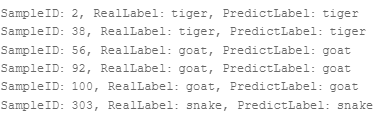

By reviewing the result, it can be believed that ResNet50 can make great classification.

# 6 Model deployment

In [15]:
model_2.save('infer/zodiac', training=False)

# CONCLUSION

In this experiment, it demonstrates that ResNet can make great classification. Fortunately, the result shows a good demonstration of accuracy. However, I believe there should be a more detailed way to quantify the result comprehensively, maybe next time I should try to find some other evaluation metrics to measure the performance of this model. For example, we use Manhattan distance to measure the accuracy of K-means or Fréchet inception distance (FID) in generative model.

To sum up, residual network or ResNet was a major innovation that has changed the training of deep convolutional neural networks for tasks related to computer vision. While the original Resnet had 34 layers and used 2-layer blocks, other advanced variants such as the Resnet50 made the use of 3-layer bottleneck blocks to ensure improved accuracy and lesser training time. 
